XGBoost参数调优示例
==========
参考网友翻译好的指南[链接](https://www.cnblogs.com/mfryf/p/6293814.html)，和另一个实例[House Price](https://github.com/ptiwaree/Kaggle-House-Prices/blob/master/Modeling/House%20Prices%20-%20Boosting-3.ipynb)

In [14]:
#导入必要的库
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy import stats

import xgboost as xgb
from sklearn import  metrics
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [10]:
#载入数据(数据是已经经过特征工程处理的数据)
train = pd.read_csv("processed_train.csv")
test = pd.read_csv("processed_test.csv")


In [11]:
train.head()

,Unnamed: 0,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,...,0,0,1,0,0,0,0,1,0,12.247699
1,1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,...,0,0,1,0,0,0,0,1,0,12.109016
2,2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,...,0,0,1,0,0,0,0,1,0,12.317171
3,3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,...,0,0,1,1,0,0,0,0,0,11.849405
4,4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,...,0,0,1,0,0,0,0,1,0,12.429220


In [18]:
#将train分离出“特征”X_train和最终的“目标”SalePrice
X_train = train.loc[:,'MSSubClass':'SaleCondition_Partial']
y = train.loc[:,'SalePrice']
#y.describe()

count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: SalePrice, dtype: float64

In [22]:
test.head()
test.drop('Unnamed: 0', axis=1, inplace=True)
test.head(2)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3.044522,4.394449,9.360741,5,6,1961,1961,0.000000,6.150603,4.976734,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.406719,9.565775,6,6,1958,1958,4.691348,6.828712,0.000000,...,0,0,0,1,0,0,0,0,1,0


In [23]:
X_train.shape, y.shape, test.shape

((1460, 288), (1460,), (1459, 288))

### 建立一个函数来帮助找到合适的models,并进行交叉验证
#### Function to fit model and do Cross Validation for error calculation

In [39]:
def modelfit(model, dtrain, features, output, performCV=True, printFeatureImportance=True, cv_folds=5, early_stopping_rounds=50):
    #Perform cross-validation
    if performCV:
        cv_score = cross_val_score(model, dtrain[features], output, cv=cv_folds)
        
    #fit the algorithm on the data
    model.fit(dtrain[features], output, eval_metric='auc')
    
    #Predicr the training set
    dtrain_predictions = model.predict(dtrain[features])
    #dtrain_predprob = model.predict_proba(dtrain[features])[:,1]
    
    #Print the model report
    print("\nModel Report")
    print("R-Square: %.5f"%metrics.r2_score(output, dtrain_predictions))
    print("rmse: %.5f" % np.sqrt(metrics.mean_squared_error(output, dtrain_predictions)))
    #print("cv_score: ", cv_score)
    
    if performCV:
        print("CV_Score: Mean: %.7g | Std: %.7g | Min: %.7g | Max: %.7g" % (np.mean(cv_score),np.std(cv_score),
                                                                 np.min(cv_score),np.max(cv_score)))
    #Print feature importance
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_[0:30], features[0:30]).sort_values(ascending=False)
        feat_imp.plot(kind="bar", title="Top 30 Feature Importances")
        plt.ylabel("Features Importance Score")
    
    
    

(1460, 288) (1460,)

Model Report
R-Square: 0.95297
rmse: 0.08660
CV_Score: Mean: 0.8920431 | Std: 0.01035349 | Min: 0.8822041 | Max: 0.9100239


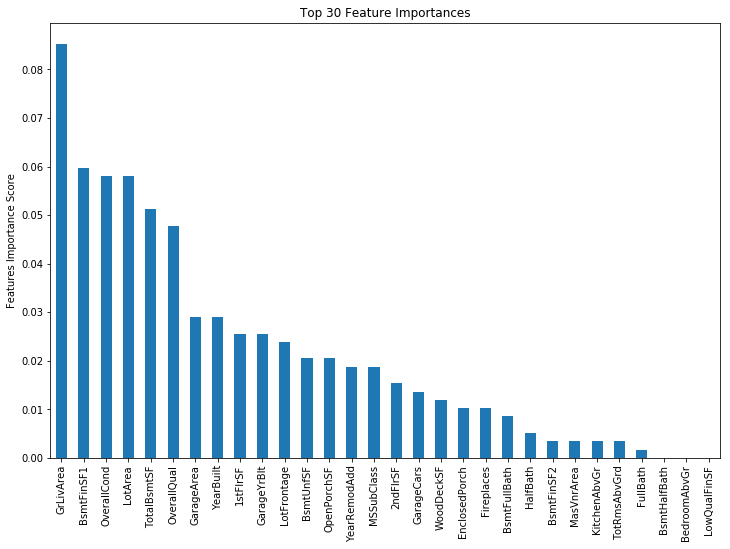

In [40]:
#先看看没有进行调参的模型结果
features = X_train.columns
print(X_train[features].shape, y.shape)
model_xgb = xgb.XGBRegressor() #the params were tuned using xgb.cv
matplotlib.rcParams['figure.figsize'] = (12,8)
modelfit(model_xgb, X_train, features, y)

# `调优--Parameter Tuning`
### xgboost.XGBRegressor()主要参数介绍：
* **booster[默认gbtree]**  
    * 选择每次迭代的模型，有两种:
     * gbtree：基于树的模型
     * gbliner：线性模型

    
* **learning_rate[默认0.1]:**学习率 
       
       
* **max_depth[默认3]**
    * 树的最大深度，用来避免过拟合。max_depth越大模型会学到根具体更局部的特征。__需要调优__


* **gamma[默认0]**
    * 在节点分裂时只有分裂后损失函数的值下降了才会分裂这个节点。
    * gamma指定了节点分裂所需的最小损失函数下降值，gamma值越大算法越保守
    
    
* **subsample[默认1]**
    * 训练每棵树时用来训练的数据占全部的比例（随机采样比例）。用于防止 Overfitting。
    * 减少这个参数值，算法会变得保守，避免过拟合；如果设置过小会导致欠拟合。（典型值0.5-1）
    

* **colsample_bytree[默认1]**
    * 控制每棵随机采样的列数的占比（即，训练每棵树时用来训练的特征的比例）。类似 RandomForestClassifier 的 max_features
    
    
* **min_child_weight[默认1]**  
    * 决定最小叶子节点样本权重和。 和GBM的 min_child_leaf 参数类似，但不完全一样。XGBoost的这个参数是最小样本权重的和，而GBM参数是最小样本总数。
    *  这个参数用于避免过拟合。当它的值较大时，可以避免模型学习到局部的特殊样本。 但是如果这个值过高，会导致欠拟合。这个参数需要使用CV来调整。
    
    
* **max_delta_step[默认0]**
    * 用来限制每棵树权重改变的最大步长，值为0表示没有约束
    
    
* **objective[默认reg:linear]** 
    * 这个参数定义需要被最小化的损失函数。最常用的值有：binary:logistic 二分类的逻辑回归，返回预测的概率(不是类别)。 multi:softmax 使用softmax的多分类器，返回预测的类别(不是概率)。
    
    
* **reg_lambda**
    * 权重的L2正则化项
    
    
* **reg_alpha**
    * 权重的L1正则化项
    

* **silent[默认值True]**
    * 当为True时静默模式开启，不会输出任何信息。
    

* **n_estimators**
    * 决策树的数量，对模型效果重要，需要调优。


* **scale_pos_weight[默认1]**
    * 在各类别样本十分不平衡时，参数设定为正值，可以使算法更快收敛

### 第一步，确定学习速率和tree_based 参数调优的估计器数目
先确定一个学习率（一般设置为0.1），选择对应于此学习速率的理想决策树数量。XGBoost有一个很有用的函数“cv”，这个函数可以在每一次迭代中使用交叉验证，并返回理想的决策树数量     
先给其他参数设置一个初始值：   
* max_depth = 4 : 这个参数的取值最好在3-10之间
* gamma = 0 :
* subsample = 0.8 :
* colsample_bytree = 0.8 : 
* min_child_weight = 1 : 因为这是一个不平衡的问题，某些叶子节点的值会比较小
* scale_pos_weight = 1 : 类别不平衡，设置为正值

In [52]:
xgb1 = xgb.XGBRegressor(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8
        )
param_test1 = {'n_estimators':list(range(20,501,10))}

gsearch1 = GridSearchCV(estimator=xgb.XGBRegressor( learning_rate=0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8), 
        param_grid=param_test1, iid=False,cv=5)

In [53]:
gsearch1.fit(X_train[features], y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [54]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -11.87809, std: 0.93095, params: {'n_estimators': 20},
  mean: -0.73260, std: 0.12630, params: {'n_estimators': 30},
  mean: 0.66726, std: 0.02843, params: {'n_estimators': 40},
  mean: 0.84987, std: 0.00952, params: {'n_estimators': 50},
  mean: 0.87743, std: 0.00613, params: {'n_estimators': 60},
  mean: 0.88438, std: 0.00719, params: {'n_estimators': 70},
  mean: 0.88779, std: 0.00831, params: {'n_estimators': 80},
  mean: 0.89058, std: 0.00867, params: {'n_estimators': 90},
  mean: 0.89239, std: 0.00936, params: {'n_estimators': 100},
  mean: 0.89312, std: 0.00978, params: {'n_estimators': 110},
  mean: 0.89435, std: 0.00935, params: {'n_estimators': 120},
  mean: 0.89479, std: 0.00922, params: {'n_estimators': 130},
  mean: 0.89514, std: 0.00983, params: {'n_estimators': 140},
  mean: 0.89539, std: 0.01004, params: {'n_estimators': 150},
  mean: 0.89557, std: 0.01004, params: {'n_estimators': 160},
  mean: 0.89586, std: 0.01028, params: {'n_estimators': 170},
  mean: 0.896

可以看出来，在学习率为0.1时，理想的决策树数目为370.

### 第二步，对max_depth和min_child_weight参数调优
这两个参数对模型效果影响很大，在前面确定的学习率和理想的决策树数目之后，先对这两个参数进行微调

In [55]:
gsearch1.best_params_['n_estimators']

370

In [56]:
param_test2 = {
    'max_depth':list(range(3,10,1)),
    'min_child_weight':list(range(1,6,1))
}

gsearch2 = GridSearchCV(estimator=xgb.XGBRegressor( learning_rate=0.1,
        n_estimators=gsearch1.best_params_['n_estimators'],
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8), 
        param_grid=param_test2, n_jobs=4, iid=False,cv=5)

gsearch2.fit(X_train[features], y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.90092, std: 0.00877, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.90206, std: 0.00962, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.90198, std: 0.00901, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.90359, std: 0.01043, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.90262, std: 0.01018, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.89809, std: 0.01098, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.90061, std: 0.01107, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.89992, std: 0.00963, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.90352, std: 0.00918, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.90305, std: 0.01073, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.89807, std: 0.00838, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.89893, std: 0.00929, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.89794, std: 0.01261, params: {

使用GridSearch对给定的参数暴力搜索之后，可以得到理想的树的最大深度为3，min_child_weight理想取值为4。  
同时可以看到cv的得分也有了一点点的提升

### 第三步，gamma参数调优

In [59]:
param_test3 = {'gamma':[i/10.0 for i in range(0,10)]}

gsearch3 = GridSearchCV(estimator=xgb.XGBRegressor( learning_rate=0.1,
        n_estimators=gsearch1.best_params_['n_estimators'],
        max_depth=gsearch2.best_params_['max_depth'],
        min_child_weight=gsearch2.best_params_['min_child_weight'],
        subsample=0.8,
        colsample_bytree=0.8), 
        param_grid=param_test3, n_jobs=4, iid=False,cv=5)

gsearch3.fit(X_train[features], y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.90359, std: 0.01043, params: {'gamma': 0.0},
  mean: 0.89774, std: 0.00968, params: {'gamma': 0.1},
  mean: 0.88894, std: 0.00996, params: {'gamma': 0.2},
  mean: 0.87983, std: 0.00996, params: {'gamma': 0.3},
  mean: 0.87410, std: 0.01269, params: {'gamma': 0.4},
  mean: 0.86849, std: 0.01066, params: {'gamma': 0.5},
  mean: 0.86568, std: 0.01190, params: {'gamma': 0.6},
  mean: 0.86353, std: 0.01322, params: {'gamma': 0.7},
  mean: 0.85815, std: 0.01469, params: {'gamma': 0.8},
  mean: 0.85772, std: 0.01221, params: {'gamma': 0.9}],
 {'gamma': 0.0},
 0.9035853793838815)

gamma的理想值和开始设置的一样，一个模型的参数相当于和前一个完全一致，所以cv的得分没有变化  


#### 在优化了n_eatimators,max_depth,min_child_weight和gamma之后，可以对比看一下部分参数优化之后的模型与刚开始的默认参数模型（baseline model）效果上的区别


Model Report
R-Square: 0.98137
rmse: 0.05451
CV_Score: Mean: 0.9029528 | Std: 0.01330706 | Min: 0.8826236 | Max: 0.9184255


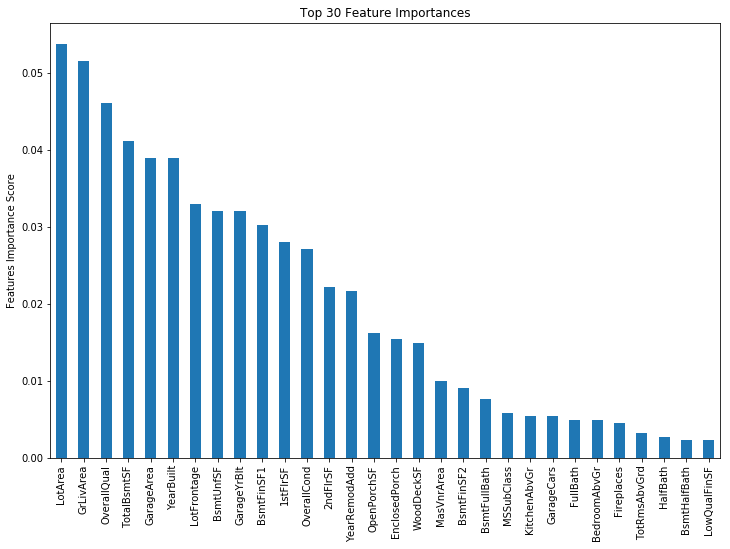

In [60]:
xgb2 = xgb.XGBRegressor(learning_rate=0.1,
                       n_estimators=370,
                       max_depth=3,
                       min_child_weight=4,
                       gamma=0.0)

matplotlib.rcParams['figure.figsize'] = (12,8)
modelfit(xgb2, X_train, features, y)

和baseline model对比，可以看到R-Square值提高，均方根误差rmse降低，得分提高了，这是好现象。  

还有参数可以调优：subsample,colsample_bytree  

### 第四步，优化subsample和colsample_bytree参数

In [62]:
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=0.1,
        n_estimators=370,
        max_depth=3,
        min_child_weight=4,
        gamma=0.0),
        param_grid=param_test4, n_jobs=4, iid=False, cv=5)

gsearch4.fit(X_train[features], y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.89889, std: 0.01294, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.90116, std: 0.01698, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.90423, std: 0.00958, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.90467, std: 0.01180, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.89971, std: 0.01195, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.90274, std: 0.01118, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.90317, std: 0.00875, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.90428, std: 0.01139, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.90179, std: 0.01170, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.90071, std: 0.00982, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.90359, std: 0.01043, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.90419, std: 0.01084, params: {'subsample': 0.9, 'colsample_bytree'

可以看出subsample的理想取值为0.8，colsample_bytree的理想取值为0.9.  
现在以0.05为步长，在理想值附近尝试取值

In [65]:
param_test5 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(80,95,5)]
}

gsearch5 = GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=0.1,
        n_estimators=370,
        max_depth=3,
        min_child_weight=4,
        gamma=0.0),
        param_grid=param_test5, n_jobs=4, iid=False, cv=5)

gsearch5.fit(X_train[features], y)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.90361, std: 0.00904, params: {'subsample': 0.75, 'colsample_bytree': 0.8},
  mean: 0.90359, std: 0.01043, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.90466, std: 0.01003, params: {'subsample': 0.85, 'colsample_bytree': 0.8},
  mean: 0.90337, std: 0.00808, params: {'subsample': 0.75, 'colsample_bytree': 0.85},
  mean: 0.90656, std: 0.01112, params: {'subsample': 0.8, 'colsample_bytree': 0.85},
  mean: 0.90244, std: 0.01030, params: {'subsample': 0.85, 'colsample_bytree': 0.85},
  mean: 0.90408, std: 0.01289, params: {'subsample': 0.75, 'colsample_bytree': 0.9},
  mean: 0.90609, std: 0.00858, params: {'subsample': 0.8, 'colsample_bytree': 0.9},
  mean: 0.90439, std: 0.01197, params: {'subsample': 0.85, 'colsample_bytree': 0.9}],
 {'colsample_bytree': 0.85, 'subsample': 0.8},
 0.9065630595743261)

经过小范围的微调之后，subsample的取值还是0.8，colsample_bytree的取值变为0.85

### 第五步，正则化参数（reg_alpha,reg_lambda）调优
一般机器学习的模型会加入正则项以降低过拟合的问题，xgboost中的gamma其实已经提供了有效降低过拟合的方法，这里再展示如何去调优正则化参数。  
先优化L1正则化的参数“reg_alpha”

In [70]:
param_test6 = {'reg_alpha':[1e-6, 1e-5, 1e-3, 0.01, 0.1, 0, 1, 10, 100]}

gsearch6 = GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=0.1,
        n_estimators=370,
        max_depth=3,
        min_child_weight=4,
        gamma=0.0,
        subsample=0.8,
        colsample_bytree=0.85),
        param_grid=param_test6, n_jobs=4, iid=False, cv=5)

gsearch6.fit(X_train[features], y)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.90657, std: 0.01112, params: {'reg_alpha': 1e-06},
  mean: 0.90657, std: 0.01112, params: {'reg_alpha': 1e-05},
  mean: 0.90437, std: 0.01046, params: {'reg_alpha': 0.001},
  mean: 0.90409, std: 0.01089, params: {'reg_alpha': 0.01},
  mean: 0.90229, std: 0.01040, params: {'reg_alpha': 0.1},
  mean: 0.90656, std: 0.01112, params: {'reg_alpha': 0},
  mean: 0.90367, std: 0.01129, params: {'reg_alpha': 1},
  mean: 0.86137, std: 0.02120, params: {'reg_alpha': 10},
  mean: 0.55379, std: 0.04570, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.9065704304962192)

这里求出的reg_alpha的理想值为1e-5,cv得分比没调优前高了一点点   

下面调优L2正则化参数“reg_lambda”

param_test7 = {'reg_lambda':[1e-5, 1e-3, 0.01, 0.1, 0, 1, 5, 10, 100]}

gsearch7 = GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=0.1,
        n_estimators=370,
        max_depth=3,
        min_child_weight=4,
        gamma=0.0,
        subsample=0.8,
        colsample_bytree=0.85,
        reg_alpha=1e-5),
        param_grid=param_test7, n_jobs=4, iid=False, cv=5)

gsearch7.fit(X_train[features], y)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

发现reg_lambda最优值还是默认的1，当然还可以在1的附近小范围内尝试取值，这里省略，直接用默认的取值1。

### 第六步，优化学习率learning_rate


Model Report
R-Square: 0.98866
rmse: 0.04253
CV_Score: Mean: 0.9093866 | Std: 0.01144901 | Min: 0.8967827 | Max: 0.9251864


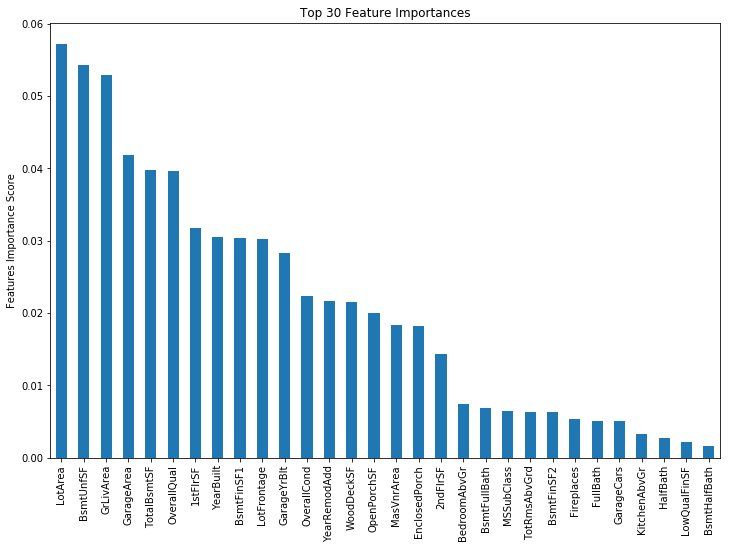

In [72]:
#将学习率减小为0.01，同时增加决策树数量
xgb3 = xgb.XGBRegressor(learning_rate=0.01,
                       n_estimators=5000,
                       max_depth=3,
                       min_child_weight=4,
                       gamma=0.0,
                       subsample=0.8,
                       colsample_bytree=0.85,
                       reg_alpha=1e-5)

matplotlib.rcParams['figure.figsize'] = (12,8)
modelfit(xgb3, X_train, features, y)


Model Report
R-Square: 0.99895
rmse: 0.01292
CV_Score: Mean: 0.9070256 | Std: 0.01084551 | Min: 0.893893 | Max: 0.9230967


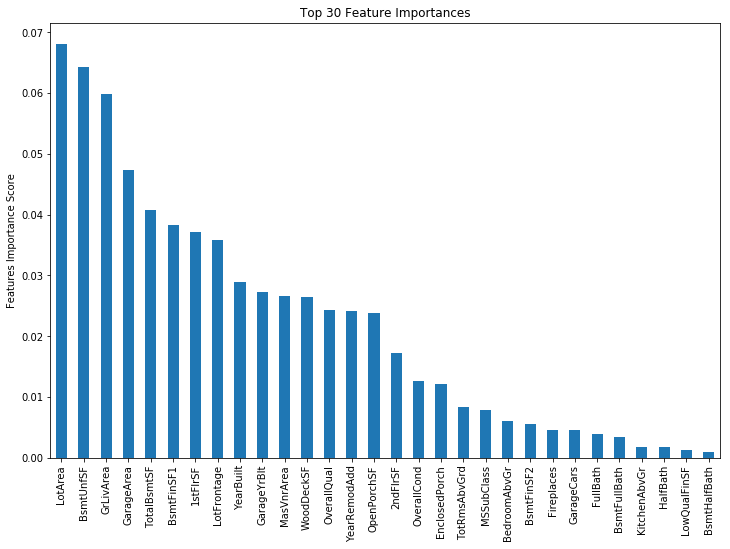

In [95]:
#将学习率减小为0.03
xgb4 = xgb.XGBRegressor(learning_rate=0.03,
                       n_estimators=5000,
                       max_depth=3,
                       min_child_weight=4,
                       gamma=0.0,
                       subsample=0.8,
                       colsample_bytree=0.85,
                       reg_alpha=1e-5)

matplotlib.rcParams['figure.figsize'] = (12,8)
modelfit(xgb4, X_train, features, y)

用参数调优后的模型对测试集进行预测
--------------------------------------

In [104]:
model_xgb = xgb.XGBRegressor(learning_rate=0.003,
                       n_estimators=50000,
                       max_depth=3,
                       min_child_weight=4,
                       gamma=0.0,
                       subsample=0.8,
                       colsample_bytree=0.85,
                       reg_alpha=1e-5)
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0.0, learning_rate=0.003,
       max_delta_step=0, max_depth=3, min_child_weight=4, missing=None,
       n_estimators=50000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [105]:
#预测
xgb_predictors = np.expm1(model_xgb.predict(test))

In [106]:
original_test = pd.read_csv('test.csv')
result = pd.DataFrame({'Id':original_test.Id, 'SalePrice':xgb_predictors})
result.describe()

,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,178318.812500
std,421.321334,77457.367188
min,1461.000000,37212.519531
25%,1825.500000,127850.980469
50%,2190.000000,157654.906250
75%,2554.500000,209518.562500
max,2919.000000,570413.687500


In [107]:
# 保存为csv文件
result.to_csv('20171230xgboost.csv')

# 总结  
仅仅靠参数调优可以给模型带来一些优化，但是很难让模型的效果有质的提高； 
想要模型表现的更好，往往还依赖其他手段，如feature egineering, ensemble, stacking等。